In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 14

from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [6]:
full_df = pd.read_csv('../../data/full_df.csv',index_col=False)
user_products = pd.read_csv('../../data/user_products.csv',index_col=False)

## Baseline Model: Simple Prediction
The baseline I want to establish is predicting if a user will reorder a product based on his/her most recent order

In [ ]:
# #get unique user-product where the user_id is in the train set 
# orders = user_products[user_products['user_id'].isin(user_products[user_products['eval_set']=='train']['user_id'])] \
#                            .drop_duplicates(['user_id', 'product_id'])
# # orders.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
#get unique user-product where the user_id is in the train set 
# test  = user_products[user_products['eval_set'] == 'train' ]
# user_ids = test['user_id'].values
# orders = user_products[user_products['user_id'].isin(user_ids)]

<AxesSubplot:>

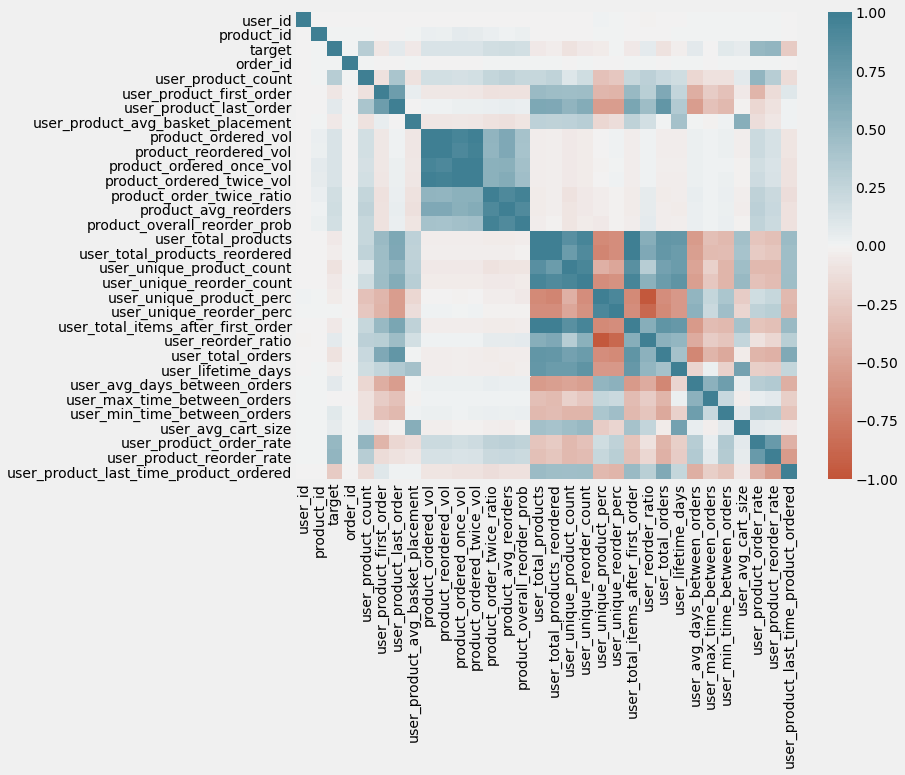

In [22]:
sns.heatmap(full_df.corr(),vmin=-1, vmax=1, center=0,
           cmap=sns.diverging_palette(20, 220, n=200))
# full_df.drop('Unnamed: 0',axis=1,inplace=True)

In [14]:
full_df.target.value_counts(normalize=True)

0    0.9022
1    0.0978
Name: target, dtype: float64

In [ ]:
train_df = full_df[['user_id','product_id','target']][full_df.]

Creating DF that contains products from max_order-1 

In [10]:
test  = user_products[user_products['eval_set'] == 'train' ]
user_ids = test['user_id'].values
orders = user_products[user_products['user_id'].isin(user_ids)]

In [15]:
prior_orders = orders[orders.eval_set=='prior'][['user_id','product_id','reordered','order_number']]
prior_orders

,user_id,product_id,reordered,order_number
828824,202279,33120,1,3
828825,202279,28985,1,3
828826,202279,9327,0,3
828827,202279,45918,1,3
828828,202279,30035,0,3
...,...,...,...,...
33263298,175185,16797,0,23
33263299,175185,43352,1,23
33263300,175185,32700,1,23
33263301,175185,12023,0,23


In [18]:
prior_orders.groupby('user_id').order_number.max()

user_id
1         10
2         14
5          4
7         20
8          3
          ..
206199    19
206200    23
206203     5
206205     3
206209    13
Name: order_number, Length: 122607, dtype: int64

Create dataframe that has the most recent products ordered per user from the prior dataset

In [19]:
idx = prior_orders.groupby(['user_id'])['order_number'].transform(max) == prior_orders['order_number']
max_orders=prior_orders[idx]

In [20]:
max_orders.rename(columns={'reordered':'ordered_last_order'},inplace=True)
max_orders.sort_values('user_id')

/Users/tiffany.chen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,user_id,product_id,ordered_last_order,order_number
25010093,1,38928,0,10
25010097,1,13032,1,10
25010098,1,12427,1,10
25010094,1,25133,1,10
25010092,1,39657,0,10
...,...,...,...,...
29064891,206209,31477,0,13
29064892,206209,6567,0,13
29064887,206209,16168,1,13
29064893,206209,22920,0,13


In [23]:
max_orders['predicted'] = 1
max_orders

<ipython-input-23-8db1e39a99eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_orders['predicted'] = 1


,user_id,product_id,ordered_last_order,order_number,predicted
829043,59897,9755,1,19,1
829044,59897,31487,0,19,1
829045,59897,37510,1,19,1
829046,59897,14576,1,19,1
829047,59897,22105,0,19,1
...,...,...,...,...,...
33263096,123577,19678,0,6,1
33263097,123577,48775,1,6,1
33263098,123577,44047,0,6,1
33263244,103510,49187,0,30,1


Create dataframe with most recent order from training dataset we're using to predict on

In [ ]:
# train_orders = orders[orders.eval_set=='train'][['user_id','product_id','reordered','order_number']]
# # train_orders = orders[['user_id','product_id','reordered','order_number']]
# train_orders.sort_values('user_id')

In [ ]:
train_orders = train_construct

Merge 2 dataframes, with training data as the base, and fill with 0 if product isn't ordered

In [ ]:
baseline = pd.merge(train_orders[['user_id','product_id','actual']],max_orders[['user_id','product_id','predicted']],how='left',on=['user_id','product_id'])
baseline.isnull().sum()
baseline.predicted.fillna(0,inplace=True)
baseline.predicted.value_counts()
# baseline.rename(columns={'reordered':'actual','target':'predicted'},inplace=True)

# baseline.astype({'actual': 'int32','predicted':'int32'}).dtypes
baseline


In [ ]:
baseline[(baseline.predicted==1)]

In [ ]:
baseline.predicted.value_counts(normalize=True)

In [ ]:
baseline.actual.value_counts(normalize=True)

In [ ]:
y_actual = baseline.actual
y_pred = baseline.predicted
cmt = pd.DataFrame(metrics.confusion_matrix(y_true=y_actual, y_pred=y_pred), 
                  columns=['Negative Pred', 'Positive Pred'])
cmt

In [ ]:
tn = cmt.iloc[0,0]
fn = cmt.iloc[1,0]
fp = cmt.iloc[0,1]
tp = cmt.iloc[1,1]
accuracy = (tp+tn) / (tp+tn+fp+fn)
accuracy
sensitivity = (tp) / (tp+fn)
ppv = tp / (tp+fp)
print(accuracy, ',', sensitivity, ',', ppv)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_actual, y_pred)

If the model were to predict all reorders, the model's accuracy would be 60%
Using only the user's last order, prediction accuracy is slightly increased to 67% (sensitivity 45%) 
The model predicted yes 27% of the time and has a positive predictive value of 100%, indicating that the model is really good at predicting re-orders in our training dataset. 

## Baseline Model: Reorder Rate

In [ ]:
# full_df = pd.read_csv('../../data/full_df.csv')
train_df = pd.read_csv('../../data/train_df.csv')
prior_df = pd.read_csv('../../data/prior_df.csv')
# test_df = pd.read_csv('../../data/test_df.csv')

In [ ]:
train_df.head()
# train_df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
prior_df.head()
# prior_df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
pred = prior_df.groupby(['user_id','product_id']).agg(order_rate=('user_product_reorder_rate','mean')).reset_index()
pred

In [ ]:
train = train_df[['user_id','product_id','reordered']]
train.sort_values('user_id')

In [ ]:
baseline_2 = pd.merge(train,pred,how='left',on=['user_id','product_id'])
baseline_2

In [ ]:
y_actual = baseline_2.reordered

accuracy=[]
pos_pv=[]
sensitivity=[]

for i in np.arange(0.0,1.0,0.1):
    prob_thresh = i
    cm = pd.DataFrame(
        metrics.confusion_matrix(y_true=y_actual,y_pred=baseline_2.order_rate > prob_thresh),
        columns=['Negative Pred', 'Positive Pred'])
    tn = cm.iloc[0,0]
    fn = cm.iloc[1,0]
    fp = cm.iloc[0,1]
    tp = cm.iloc[1,1]

    acc = (tp+tn) / (tp+tn+fp+fn)
#     tpr = tp / (tp+fn)
#     fpr = fp / (tn+fp)
    ppv = tp / (tp+fp)
    sens = (tp) / (tp+fn)


    accuracy.append(acc)
    pos_pv.append(ppv)
    sensitivity.append(sens)
    
print(accuracy) 
print(pos_pv)
print(sensitivity)
    